<h1> Preprocessing using Dataflow </h1>

This notebook illustrates:
<ol>
<li> Creating datasets for Machine Learning using Dataflow
</ol>
<p>
While Pandas is fine for experimenting, for operationalization of your workflow, it is better to do preprocessing in Apache Beam. This will also help if you need to preprocess data in flight, since Apache Beam also allows for streaming.

Apache Beam only works in Python 2 at the moment, so we're going to switch to the Python 2 kernel. In the above menu, click the dropdown arrow and select `python2`. 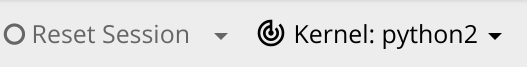

Then activate a Python 2 environment and install Apache Beam.

In [1]:
%%bash
source activate py2env
pip uninstall -y google-cloud-dataflow
conda install -y pytz==2018.4
pip install apache-beam[gcp]

Uninstalling google-cloud-dataflow-2.0.0:
  Successfully uninstalled google-cloud-dataflow-2.0.0
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/py2env

  added / updated specs: 
    - pytz==2018.4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.11.29         |           py27_0         146 KB  defaults

The following packages will be UPDATED:

    certifi: 2018.10.15-py27_0 defaults --> 2018.11.29-py27_0 defaults


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
  Running setup.py bdist_wheel for pydot: started
  Running setup.py bdist_wheel for pydot: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
  Running setup.py bdist_wheel for httplib2: started
  Ru



==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda


certifi-2018.11.29   | 146 KB    | ########## | 100% 
google-cloud-bigquery 1.6.1 has requirement google-api-core<2.0.0dev,>=1.0.0, but you'll have google-api-core 0.1.4 which is incompatible.
googledatastore 7.0.1 has requirement httplib2<0.10,>=0.9.1, but you'll have httplib2 0.11.3 which is incompatible.


After doing a pip install, click **"Reset Session"** on the notebook so that the Python environment picks up the new packages.

In [4]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-3290dfb507fcf8e3'
PROJECT = 'qwiklabs-gcp-3290dfb507fcf8e3'
REGION = 'us-east1-c'

In [5]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [6]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Save the query from earlier </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [7]:
# Create SQL query using natality data after the year 2000
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [8]:
# Call BigQuery and examine in dataframe
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.063611,True,32,1,37.0,7108882242435606404
1,4.687028,True,30,3,33.0,7170969733900686954
2,7.561856,True,20,1,39.0,6392072535155213407
3,7.561856,True,31,1,37.0,2126480030009879160
4,7.312733,True,32,1,40.0,3408502330831153141


<h2> Create ML dataset using Dataflow </h2>
Let's use Cloud Dataflow to read in the BigQuery data, do some preprocessing, and write it out as CSV files.

Instead of using Beam/Dataflow, I had three other options:

* Use Cloud Dataprep to visually author a Dataflow pipeline. Cloud Dataprep also allows me to explore the data, so we could have avoided much of the handcoding of Python/Seaborn calls above as well!
* Read from BigQuery directly using TensorFlow.
* Use the BigQuery console (http://bigquery.cloud.google.com) to run a Query and save the result as a CSV file. For larger datasets, you may have to select the option to "allow large results" and save the result into a CSV file on Google Cloud Storage. 

<p>

However, in this case, I want to do some preprocessing, modifying data so that we can simulate what is known if no ultrasound has been performed. If I didn't need preprocessing, I could have used the web console. Also, I prefer to script it out rather than run queries on the user interface, so I am using Cloud Dataflow for the preprocessing.

Note that after you launch this, the actual processing is happening on the cloud. Go to the GCP webconsole to the Dataflow section and monitor the running job. It took about 20 minutes for me.
<p>
If you wish to continue without doing this step, you can copy my preprocessed output:
<pre>
gsutil -m cp -r gs://cloud-training-demos/babyweight/preproc gs://your-bucket/
</pre>

In [11]:
import apache_beam as beam
import datetime, os

def to_csv(rowdict):
  # Pull columns from BQ and create a line
  import hashlib
  import copy
  CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')

  # Create synthetic data where we assume that no ultrasound has been performed
  # and so we don't know sex of the baby. Let's assume that we can tell the difference
  # between single and multiple, but that the errors rates in determining exact number
  # is difficult in the absence of an ultrasound.
  no_ultrasound = copy.deepcopy(rowdict)
  w_ultrasound = copy.deepcopy(rowdict)

  no_ultrasound['is_male'] = 'Unknown'
  if rowdict['plurality'] > 1:
    no_ultrasound['plurality'] = 'Multiple(2+)'
  else:
    no_ultrasound['plurality'] = 'Single(1)'

  # Change the plurality column to strings
  w_ultrasound['plurality'] = ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality'] - 1]

  # Write out two rows for each input row, one with ultrasound and one without
  for result in [no_ultrasound, w_ultrasound]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
    yield str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options = opts)
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) = 3'.format(query)

    (p 
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True))
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
    
preprocess(in_test_mode = False)

Launching Dataflow job preprocess-babyweight-features-190104-211012 ... hang on


The above step will take 20+ minutes. Go to the GCP web console, navigate to the Dataflow section and <b>wait for the job to finish</b> before you run the follwing step.

In [12]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

CommandException: One or more URLs matched no objects.


Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License